1. Cargado de librerías y funciones necesarias

In [ ]:
# cargamos librerías necesarias
import numpy  as np  
import pandas as pd

import matplotlib.pyplot as plt # para dibujar
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

In [ ]:
# definimos una función para representar el resultado del ajuste
def plot_decision_boundary_svm(X,y,h,model):
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .05  # step size in the mesh
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Zd = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Zd = Zd.reshape(xx.shape)
    
    Zp = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1] 
    Zp = Zp.reshape(xx.shape)
    
    # Error de clasificación
    ypred = model.predict(X)
    acc = accuracy_score(y, ypred)
    
    plt.figure(1, figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,c='k', facecolors='none')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.axis([x_min, x_max, y_min, y_max])
    plt.contour(xx, yy, Zd, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], levels=[-1, 0, 1])
    plt.contourf(xx, yy, Zd>0, cmap=cm, alpha=.5)
    plt.xlabel("$x_1$", fontsize=16)
    plt.ylabel("$x_2$", fontsize=16)
    msg = 'FRONTERA DECISION\n Accuracy: %0.2g' % acc
    plt.title(msg)
        
    plt.subplot(1, 2, 2)
    plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,c='k', facecolors='none')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.axis([x_min, x_max, y_min, y_max])
    plt.contour(xx, yy, Zd, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], levels=[-1, 0, 1])
    plt.contourf(xx, yy, Zp, cmap=cm, alpha=.5)
    plt.xlabel("$x_1$", fontsize=16)
    plt.ylabel("$x_2$", fontsize=16)
    msg = 'PROBABILIDAD\n Accuracy: %0.2g' % acc
    plt.title(msg)
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Definición de las funciones necesarias de este apartado

def secuestro(x):

  if x== 'white':
    valor = 0
  else:
    valor = 1

  return valor

2. Cargado y preparación del conjunto de datos

In [ ]:
# Cargamos la base de datos de entrenamiento
url = 'https://datos.uemc.es/owncloud/s/mSue0Hq5KihC3Vc/download?path=%2F&files=DATASET14.csv'
df = pd.read_csv(url, sep=',')

# Cargamos la base de datos de prueba
url_test = 'https://datos.uemc.es/owncloud/s/mSue0Hq5KihC3Vc/download?path=%2F&files=VALIDATION_WITHOUT_LABELS.csv'
df_test = pd.read_csv(url_test, sep=',')

# Creamos una columna de etiqueta binaria en los datos de entrenamiento
df['clase']=df['label'].apply(secuestro)

# Eliminamos las columnas label y las que no son validas segun el EDA (address, length y weight)
df = df.drop(['address', 'label', 'length','weight'], axis=1)
df_test = df_test.drop(['address', 'length','weight'], axis=1)

# Comprobamos que la carga de datos se ha llevado a cabo correctamente
print('Dataset de entrenamiento:\n', df.head())
print('Dataset sobre el que predecir:\n', df_test.head())

# Nombre y tipo de las columnas del entrenamiento
print('Columnas del dataset:\n{}\n'.format(df.dtypes))

# Cantidad de datos de cada clase
print('Datos de cada clase:\n{}\n'.format(df['clase'].value_counts()))

Dataset de entrenamiento:
    year  day  count  looped  neighbors     income  clase
0  2017   11      1       0          2  100050000      1
1  2016  132      1       0          1  100000000      1
2  2016  246      1       0          2  200000000      1
3  2016  238    456       0          1  200000000      1
4  2016   96   2821       0          1   50000000      1
Dataset sobre el que predecir:
    year  day  count  looped  neighbors     income
0  2016  298   4220       0          2   80000000
1  2016   56      4       0          1  500000000
2  2016   52   8120       0          1   50057953
3  2014   81      1       0          2  300000000
4  2016  336      1       0          2  100000000
Columnas del dataset:
year         int64
day          int64
count        int64
looped       int64
neighbors    int64
income       int64
clase        int64
dtype: object

Datos de cada clase:
0    2328979
1      33545
Name: clase, dtype: int64



3. Uso de máquinas de vectores soporte (SVM) en clasificación, también conocidas como *Support Vector Classifiers* (SVC)

Las Máquinas de Vectores de Soporte (SVMs) son un conjunto de métodos de entrenamiento supervisado que se utilizan para tareas de clasificación, regresión y detección de valores atípicos. Estas construyen un híper-plano en un espacio de alta dimensión. La correcta separación de los puntos se alcanza por el híper-plano de mayor separación a los puntos de entrenamiento más cercanos de cualquier tipo (esta distancia es el Vector de Soporte).

Sus principales ventajas son:


*   Efectivos en espacios de alta dimensión.
*   Efectivos si hay pocos datos de entrenamiento.
*   Eficientes a nivel de memoria.
*   Versátiles (diferentes kernels a elegir).

Sus principales desventajas son:
*   Susceptibles a sobre-entrenamiento.
*   Elevado coste computacional.



In [ ]:
# preparamos los datos
features = df.columns.drop(['clase'])
X = df[features].values
y = df['clase'].values

print('Dimensionalidad datos: ', X.shape)

Dimensionalidad datos:  (2362524, 6)


In [ ]:
#Paso 1: Divisón train-test
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, 
                                                    test_size=0.2, random_state=0)

print('Datos train: ', X_train.shape)
print('Datos test: ', X_test.shape)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

Datos train:  (1890019, 6)
Datos test:  (472505, 6)
(array([0, 1]), array([1863183,   26836]))
(array([0, 1]), array([465796,   6709]))


In [ ]:
# Balanceamos un poco las clases eliminando registros de la mayoritaria en los datos a usar para el entrenamiento
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy=0.5) # con 0.5 estamos diciendo que haya el doble de ejemplos de la clase mayoritaria
X_train, y_train = undersample.fit_resample(X_train, y_train)

print(np.unique(y_train,return_counts=True))

(array([0, 1]), array([53672, 26836]))


In [ ]:
# Paso 2: Búsqueda de parámetros libres
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

vectorC = np.logspace(-1, 3, 20) #el parámetro C se utiliza para penalizar los errores de clasificación
vectorG = np.logspace(-9, -1, 20) #el parámetro Gamma

param_grid = {'C': vectorC, 'gamma': vectorG}

n_folds = 3

## La forma del hiper-plano de separación depende del tipo de kernel a utilizar
## La función SVC tiene un parámetro que nos permite controlar el peso de clase
clf = SVC(kernel='rbf') #linear, sigmoid, poly, rbf (Función Radial Básica)
grid = GridSearchCV(clf, scoring='accuracy', param_grid=param_grid, cv=n_folds)
X1 = X_train[48000:54000]
y1 = y_train[48000:54000]
print(np.unique(y1,return_counts=True))

grid.fit(X1, y1)

(array([0, 1]), array([5672,  328]))


GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': array([1.00000000e-01, 1.62377674e-01, 2.63665090e-01, 4.28133240e-01,
       6.95192796e-01, 1.12883789e+00, 1.83298071e+00, 2.97635144e+00,
       4.83293024e+00, 7.84759970e+00, 1.27427499e+01, 2.06913808e+01,
       3.35981829e+01, 5.45559478e+01, 8.85866790e+01, 1.43844989e+02,
       2.33572147e+02, 3.79269019e+02, 6.15848211e+02, 1.00000000e+03]),
                         'gamma': array([1.00000000e-09, 2.63665090e-09, 6.95192796e-09, 1.83298071e-08,
       4.83293024e-08, 1.27427499e-07, 3.35981829e-07, 8.85866790e-07,
       2.33572147e-06, 6.15848211e-06, 1.62377674e-05, 4.28133240e-05,
       1.12883789e-04, 2.97635144e-04, 7.84759970e-04, 2.06913808e-03,
       5.45559478e-03, 1.43844989e-02, 3.79269019e-02, 1.00000000e-01])},
             scoring='accuracy')

In [ ]:
print(np.unique(y1,return_counts=True))

(array([0, 1]), array([5672,  328]))


best mean cross-validation score: 0.949
best parameters: {'C': 1.8329807108324356, 'gamma': 0.00029763514416313134}


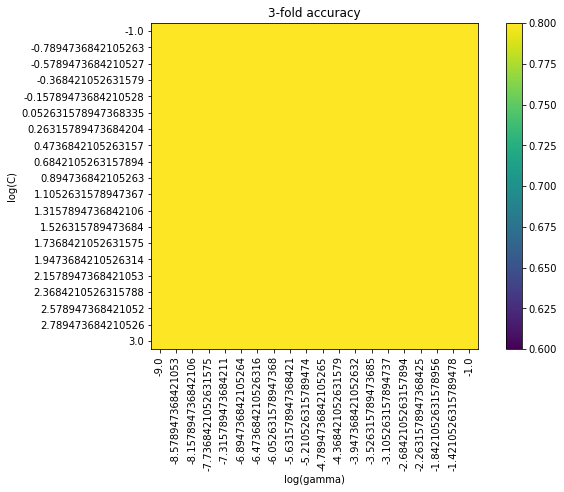

In [ ]:
# Representación de prestaciones
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score'].reshape(len(vectorC),len(vectorG))

plt.figure(figsize=(10,6))
plt.imshow(scores, interpolation='nearest', vmin=0.6, vmax=0.8)
plt.xlabel('log(gamma)')
plt.ylabel('log(C)')
plt.colorbar()
plt.xticks(np.arange(len(vectorG)), np.log10(vectorG), rotation=90)
plt.yticks(np.arange(len(vectorC)), np.log10(vectorC))
plt.title('{}-fold accuracy'.format(n_folds))
plt.show()

In [ ]:
# Paso 3: Evaluación de resultados
Copt = grid.best_params_['C']
Gopt = grid.best_params_['gamma']

svm = SVC(kernel='rbf', gamma=Gopt, C=Copt)
svm.fit(X1, y1)

print('Accuracy (TEST): %0.3f' % svm.score(X_test, y_test))
print('Accuracy (TRAIN): %0.3f' % svm.score(X_train, y_train))

Accuracy (TEST): 0.983
Accuracy (TRAIN): 0.706


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


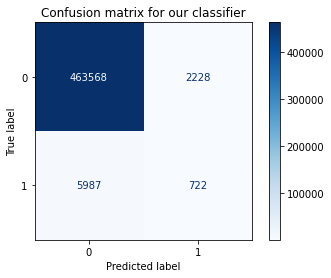

In [ ]:
# Paso 4: Matriz de confusión
from sklearn.metrics import plot_confusion_matrix

# Generate confusion matrix
svm = SVC(kernel='rbf', gamma=Gopt, C=Copt)
clf = svm.fit(X1, y1)
matrix = plot_confusion_matrix(clf, X_test, y_test,
                                 cmap=plt.cm.Blues)
plt.title('Confusion matrix for our classifier')
plt.show(matrix)
plt.show()